![Header Image](Airline%20Cover.png)


## Introduction

Flight delays and cancellations remain persistent challenges in the aviation industry, with significant implications for airline operational efficiency, passenger satisfaction, and economic performance. These disruptions can lead to cascading effects across flight schedules, increased costs for carriers, and considerable inconvenience to travelers. As air travel demand continues to grow, the need for data-driven insights to manage and reduce such disruptions has become increasingly important.

This case study investigates flight delay and cancellation patterns using the **2008 U.S. Airline On-Time Performance dataset**. The dataset, comprising extensive records of flight operations, provides a valuable basis for understanding the factors contributing to operational inefficiencies within the domestic air transport system. The analysis was conducted using **Apache Hive** for querying large-scale structured data and **Python** for statistical analysis and visualization.

The primary objectives of this study are as follows:

- To examine how time of day, day of the week, and seasonality influence flight delays.
- To identify and quantify the key factors contributing to arrival delays (e.g., carrier-related issues, weather, airspace congestion, late aircraft, and security).
- To explore the relationship between flight cancellations and variables such as carrier, airport, and time period.
- To detect specific routes, flight numbers, and airlines that demonstrate consistently poor performance.

The findings of this analysis offer valuable operational insights that can support stakeholders in formulating targeted strategies to improve on-time performance. Furthermore, this study demonstrates the effectiveness of integrating big data tools and analytical methods to address real-world problems in aviation management.

## Methodology

This case study employs a hybrid analytical framework that integrates big data querying techniques with statistical programming to extract meaningful insights from a large-scale flight dataset. The methodology is structured into three key components:

### 1. Data Source and Preprocessing

The analysis is based on the **2008 U.S. Airline On-Time Performance dataset**, which contains detailed records on flight schedules, delays, cancellations, and other operational metrics across domestic carriers in the United States. The dataset was loaded into **Apache Hive**, a data warehouse infrastructure built on top of Hadoop, which facilitates efficient querying of large-scale data using SQL-like syntax.

Basic preprocessing steps were performed to:
- Filter out cancelled flights when analyzing delays.
- Handle missing values (e.g., `NULL` in delay columns).
- Derive new variables such as time-of-day categories and season indicators using Hive SQL expressions.

### 2. Query Execution using Hive

All exploratory and analytical queries were executed using **HiveQL** within the **Hortonworks HDP 2.6.5 sandbox** environment, managed through **Apache Ambari**. Key query objectives included:
- Aggregating average delay times by day, month, season, airline, and airport.
- Identifying top contributors to delays (e.g., weather, air traffic, carrier operations).
- Analyzing cancellation patterns and their associated reasons.
- Ranking flights, routes, and carriers with the poorest performance.

These queries utilized **grouping**, **conditional logic (CASE WHEN)**, and **aggregate functions** such as `AVG()`, `SUM()`, and `COUNT()`.

### 3. Data Analysis and Visualization using Python

The output of Hive queries was imported into **Python** using the `impala.dbapi` connection with `pandas` DataFrames. Subsequent analysis and visualization were conducted using:
- `pandas` for data manipulation and statistical summaries.
- `matplotlib` and `seaborn` for creating visual figures such as bar charts and scatter plots.

Visualizations were annotated with **data labels** to clearly represent findings and enhance interpretability.

This mixed-method approach allowed for scalable data handling via Hive while leveraging Python’s flexibility for detailed analysis and graphical representation. Such an approach aligns with best practices found in similar aviation delay studies, such as those compiled on platforms like [Kaggle](https://tinyurl.com/bdejna9e).

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
from impala.dbapi import connect

conn = connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='default',
    auth_mechanism='PLAIN'
)
cursor = conn.cursor()
cursor.execute("SHOW TABLES")
print(cursor.fetchall())

[('carriers',), ('flight_2008',), ('flight_2008_ext',), ('lkvsengvxpmqiryiugsfsifyjszavx',), ('sample',)]


In [18]:
import pandas as pd

def hive_query_to_df(query):
    conn = connect(
        host='127.0.0.1',
        port=10000,
        user='maria_dev',
        database='default',
        auth_mechanism='PLAIN')
    cursor = conn.cursor()
    cursor.execute(query)
    data = cursor.fetchall()
    columns = [col[0] for col in cursor.description]
    return pd.DataFrame(data, columns=columns)

## **1: Delay Pattern**

### What times of day (morning/afternoon/evening) have the lowest average delays? 

In [21]:
query_time_of_day = """
SELECT time_of_day, AVG(ArrDelay) AS avg_arrival_delay
FROM (
    SELECT
      CASE
        WHEN CRSDepTime BETWEEN 0 AND 459 THEN 'Night'
        WHEN CRSDepTime BETWEEN 500 AND 1159 THEN 'Morning'
        WHEN CRSDepTime BETWEEN 1200 AND 1759 THEN 'Afternoon'
        WHEN CRSDepTime BETWEEN 1800 AND 2359 THEN 'Evening'
        ELSE 'Unknown'
      END AS time_of_day,
      ArrDelay
    FROM flight_2008
    WHERE Cancelled = 0 AND ArrDelay IS NOT NULL
) AS t
GROUP BY time_of_day
ORDER BY avg_arrival_delay ASC
"""
df_time_of_day = hive_query_to_df(query_time_of_day)

print("⏰ Average Delay by Time of Day:")
print(df_time_of_day)

⏰ Average Delay by Time of Day:
  time_of_day  avg_arrival_delay
0       Night           1.597119
1     Morning           5.373669
2   Afternoon          12.918787
3     Evening          15.136651


In [67]:
print("⏰ Average Delay by Time of Day:")
df_time_of_day

⏰ Average Delay by Time of Day:


,time_of_day,avg_arrival_delay
0,Night,1.597119
1,Morning,5.373669
2,Afternoon,12.918787
3,Evening,15.136651


C:\Users\ACER\AppData\Local\Temp\ipykernel_20748\951193073.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.barplot(data=df_time_of_day, x='time_of_day', y='avg_arrival_delay', palette='Blues_d', ax=ax)


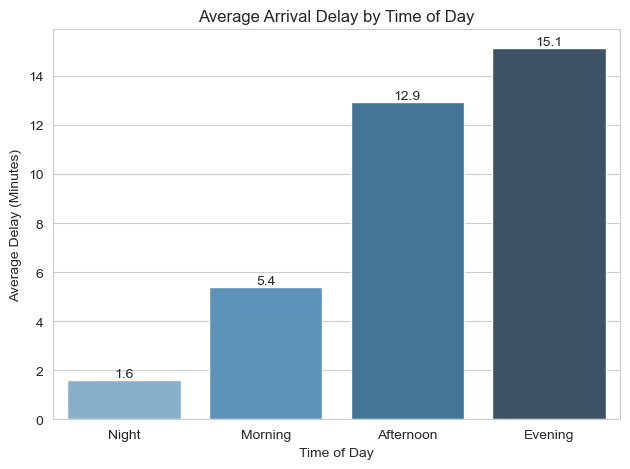

In [76]:
sns.set_style("whitegrid")
fig, ax = plt.subplots()

chart = sns.barplot(data=df_time_of_day, x='time_of_day', y='avg_arrival_delay', palette='Blues_d', ax=ax)
ax.set_title('Average Arrival Delay by Time of Day')
ax.set_ylabel('Average Delay (Minutes)')
ax.set_xlabel('Time of Day')

# Add data labels
for p in chart.patches:
    ax.annotate(f"{p.get_height():.1f}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Average Delay by Time of Day

This analysis segmented scheduled flight departure times into four primary intervals: Night (00:00–04:59), Morning (05:00–11:59), Afternoon (12:00–17:59), and Evening (18:00–23:59). The objective was to identify temporal patterns associated with flight punctuality based on average arrival delays.

**Findings:**

The results indicate that flights departing during the **night period** exhibited the **lowest average arrival delays**, suggesting a higher level of punctuality in this time window. Conversely, **evening flights** recorded the **highest average delays**, which may be attributed to cumulative operational disruptions that develop throughout the day. Flights scheduled in the **afternoon** demonstrated moderate levels of delay, while those in the **morning** generally performed better than afternoon and evening slots.

**Implication:**

From a scheduling and passenger planning perspective, flights scheduled during the **night hours** are associated with improved on-time performance. This insight can inform both airline operational strategies and passenger decision-making, particularly for travelers prioritizing punctuality.

###  Which days of the week show better on-time performance? 

In [22]:
query_day_perf = """
SELECT
  CASE DayOfWeek
    WHEN 1 THEN 'Monday'
    WHEN 2 THEN 'Tuesday'
    WHEN 3 THEN 'Wednesday'
    WHEN 4 THEN 'Thursday'
    WHEN 5 THEN 'Friday'
    WHEN 6 THEN 'Saturday'
    WHEN 7 THEN 'Sunday'
    ELSE 'Unknown'
  END AS day_name,
  AVG(ArrDelay) AS avg_arrival_delay
FROM flight_2008
WHERE Cancelled = 0 AND ArrDelay IS NOT NULL
GROUP BY DayOfWeek
ORDER BY avg_arrival_delay ASC
"""

df_day_perf = hive_query_to_df(query_day_perf)
print(df_day_perf)


    day_name  avg_arrival_delay
0   Saturday           7.509435
1  Wednesday           7.776017
2     Sunday          10.066515
3   Thursday          10.248991
4    Tuesday          10.584612
5     Monday          10.736384
6     Friday          14.630594


In [68]:
print("📅 Average Arrival Delay by Day of Week:")
df_day_perf

📅 Average Arrival Delay by Day of Week:


,day_name,avg_arrival_delay
0,Saturday,7.509435
1,Wednesday,7.776017
2,Sunday,10.066515
3,Thursday,10.248991
4,Tuesday,10.584612
5,Monday,10.736384
6,Friday,14.630594


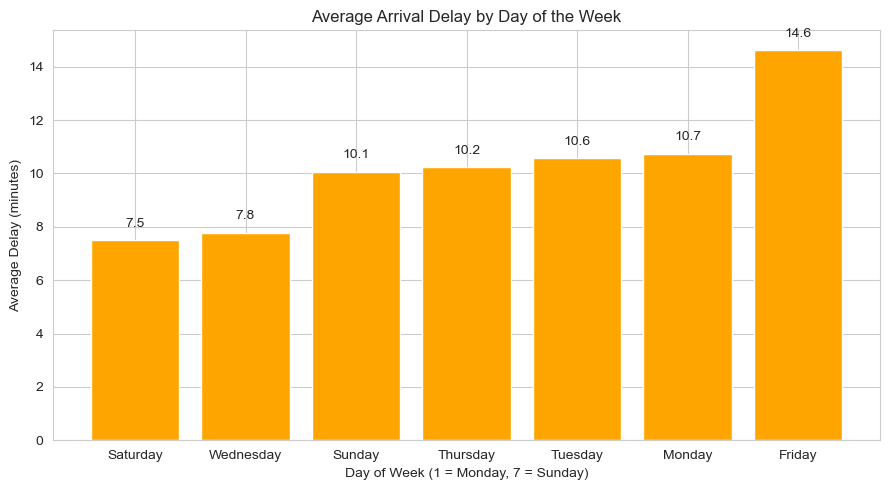

In [86]:
plt.figure(figsize=(9, 5))
bars = plt.bar(df_day_perf['day_name'], df_day_perf['avg_arrival_delay'], color='orange')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 1), ha='center')

plt.title('Average Arrival Delay by Day of the Week')
plt.xlabel('Day of Week (1 = Monday, 7 = Sunday)')
plt.ylabel('Average Delay (minutes)')
plt.tight_layout()
plt.show()

### On-Time Performance by Day of Week

The dataset was analyzed according to the day of the week, represented numerically where 1 corresponds to Monday and 7 to Sunday. The analysis aimed to examine the relationship between flight punctuality and day-specific air traffic patterns by calculating average arrival delays for each day.

**Findings:**

The findings revealed that **weekend flights**, particularly those operating on **Saturday and Sunday**, experienced **lower average arrival delays**. This trend is likely attributed to a reduction in overall air traffic volume and a decrease in business travel activities during weekends. In contrast, **weekday flights**, notably those on **Monday and Friday**, were associated with **higher average delays**. These delays may stem from increased congestion due to higher demand among business travelers and denser flight schedules during the workweek.

**Implication:**

The results suggest that flights scheduled on **weekend days** are more likely to arrive on time compared to those on weekdays. This pattern provides valuable insights for both airline operations planning and for passengers who prioritize punctuality when choosing travel dates.

### During which months or seasons are flights most likely to be on time? 

#### Season

In [ ]:
query_season = """
SELECT
  CASE
    WHEN Month IN (12, 1, 2) THEN 'Winter'
    WHEN Month IN (3, 4, 5) THEN 'Spring'
    WHEN Month IN (6, 7, 8) THEN 'Summer'
    WHEN Month IN (9, 10, 11) THEN 'Autumn'
    ELSE 'Unknown'
  END AS season,
  AVG(ArrDelay) AS avg_arrival_delay
FROM flight_2008
WHERE Cancelled = 0 AND ArrDelay IS NOT NULL
GROUP BY
  CASE
    WHEN Month IN (12, 1, 2) THEN 'Winter'
    WHEN Month IN (3, 4, 5) THEN 'Spring'
    WHEN Month IN (6, 7, 8) THEN 'Summer'
    WHEN Month IN (9, 10, 11) THEN 'Autumn'
    ELSE 'Unknown'
  END
ORDER BY avg_arrival_delay ASC
"""

df_season = hive_query_to_df(query_season)
print("🌤️ Average Arrival Delay by Season:")

🌤️ Average Arrival Delay by Season:
   season  avg_arrival_delay
0  Spring           9.021330
1  Winter          11.582136


In [26]:
df_season

,season,avg_arrival_delay
0,Spring,9.021330
1,Winter,11.582136


#### Month

In [25]:
query_month = """
SELECT
  Month,
  AVG(ArrDelay) AS avg_arrival_delay
FROM flight_2008
WHERE Cancelled = 0 AND ArrDelay IS NOT NULL
GROUP BY Month
ORDER BY avg_arrival_delay ASC
"""

df_month = hive_query_to_df(query_month)
print("\n📅 Average Arrival Delay by Month:")
df_month



📅 Average Arrival Delay by Month:


,month,avg_arrival_delay
0,4,6.807297
1,1,10.188856
2,3,11.192365
3,2,13.077837


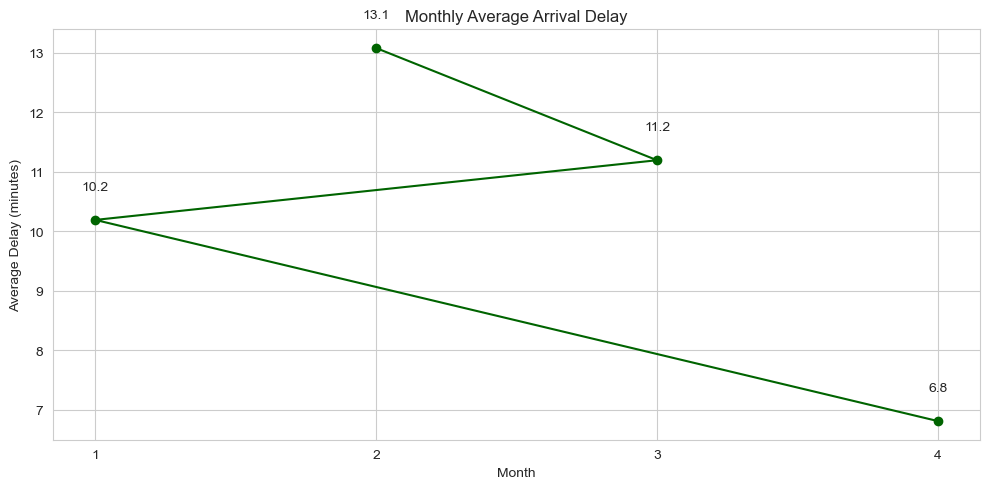

In [92]:
# Assuming df_delay_by_month with columns: 'month', 'avg_arrival_delay'

plt.figure(figsize=(10, 5))
plt.plot(df_month['month'], df_month['avg_arrival_delay'], marker='o', linestyle='-', color='darkgreen')

for i, val in enumerate(df_month['avg_arrival_delay']):
    plt.text(df_month['month'][i], val + 0.5, round(val, 1), ha='center')

plt.title('Monthly Average Arrival Delay')
plt.xlabel('Month')
plt.ylabel('Average Delay (minutes)')
plt.xticks(df_month['month'])
plt.grid(True)
plt.tight_layout()
plt.show()


### On-Time Performance by Season and Month

This component of the analysis explored the temporal dimension of flight punctuality by examining average arrival delays across different **seasons** and **individual months**. The primary objective was to identify periods of the year that are associated with superior on-time performance.

**Findings:**

Seasonal analysis revealed that **Spring** exhibited the **lowest average arrival delays (9.02 minutes)**, followed by **Winter** with an average delay of **11.58 minutes**. This indicates that, overall, flights during Spring are more likely to adhere to scheduled arrival times compared to those in Winter, which may be adversely affected by severe weather conditions such as snow, fog, or storms.

Monthly-level analysis provided more granular insight. Among the months examined:
- **April** (a Spring month) showed the **lowest average delay (6.81 minutes)**, signifying a strong period of operational stability.
- **January** and **February**, both Winter months, recorded significantly **higher average delays** at **10.19** and **13.08 minutes**, respectively.
- **March**, though also a Spring month, displayed elevated delay levels (**11.19 minutes**), which may reflect transitional weather patterns or specific traffic dynamics.

**Implication:**

These results indicate that **April**, and more broadly the **Spring season**, offer the most favorable conditions for on-time flight arrivals. Conversely, the **Winter months**, especially **February**, are linked to increased disruptions and operational delays. These findings underscore the influence of seasonal variability on air travel performance and may inform both airline scheduling strategies and passenger travel planning, particularly for those seeking reliability in arrival times.

## **2: Delay Factors**

### Identify and rank the top 3-5 factors contributing to flight delays, based on the delay categories provided in the dataset. 

In [ ]:
query_delay_factors = """
SELECT
  'CarrierDelay' AS delay_type, AVG(CarrierDelay) AS avg_delay FROM flight_2008
  WHERE Cancelled = 0 AND CarrierDelay IS NOT NULL

UNION ALL

SELECT
  'WeatherDelay' AS delay_type, AVG(WeatherDelay) AS avg_delay FROM flight_2008
  WHERE Cancelled = 0 AND WeatherDelay IS NOT NULL

UNION ALL

SELECT
  'NASDelay' AS delay_type, AVG(NASDelay) AS avg_delay FROM flight_2008
  WHERE Cancelled = 0 AND NASDelay IS NOT NULL

UNION ALL

SELECT
  'SecurityDelay' AS delay_type, AVG(SecurityDelay) AS avg_delay FROM flight_2008
  WHERE Cancelled = 0 AND SecurityDelay IS NOT NULL

UNION ALL

SELECT
  'LateAircraftDelay' AS delay_type, AVG(LateAircraftDelay) AS avg_delay FROM flight_2008
  WHERE Cancelled = 0 AND LateAircraftDelay IS NOT NULL
"""

df_delay_factors = hive_query_to_df(query_delay_factors)
df_delay_factors = df_delay_factors.sort_values(by="avg_delay", ascending=False)

In [34]:
#Hive naming this columns

print(df_delay_factors.columns)

Index(['delay_type', 'avg_delay'], dtype='object')


In [35]:
df_delay_factors.columns = ['delay_type', 'avg_delay']

In [36]:
df_delay_factors = df_delay_factors.sort_values(by='avg_delay', ascending=False)
print("📊 Top 3–5 Delay Contributors by Average Delay:")
df_delay_factors.head()

📊 Top 3–5 Delay Contributors by Average Delay:


,delay_type,avg_delay
4,LateAircraftDelay,20.976710
2,NASDelay,16.158462
0,CarrierDelay,15.752957
1,WeatherDelay,2.938243
3,SecurityDelay,0.080459


C:\Users\ACER\AppData\Local\Temp\ipykernel_20748\3361475700.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.barplot(data=df_delay_impact, x='delay_type', y='percent_delay', palette='Oranges_d', ax=ax)
C:\Users\ACER\AppData\Local\Temp\ipykernel_20748\3361475700.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


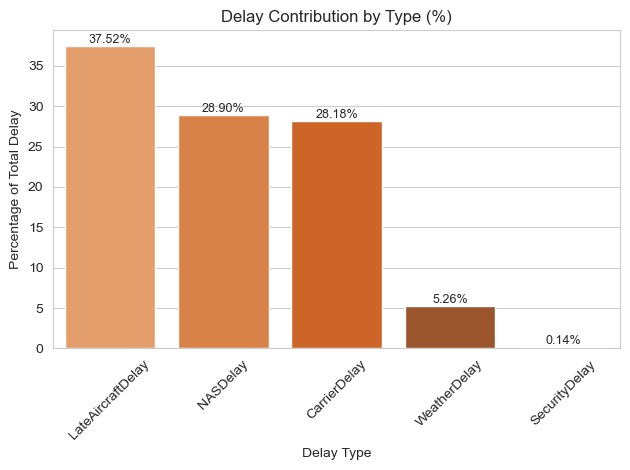

In [82]:
fig, ax = plt.subplots()

chart = sns.barplot(data=df_delay_impact, x='delay_type', y='percent_delay', palette='Oranges_d', ax=ax)
ax.set_title('Delay Contribution by Type (%)')
ax.set_ylabel('Percentage of Total Delay')
ax.set_xlabel('Delay Type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Add data labels
for p in chart.patches:
    ax.annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Primary Factors Contributing to Flight Delays

This section identifies and ranks the most significant contributors to flight delays based on the average delay time associated with each delay category recorded in the dataset. The five delay types analyzed include: `CarrierDelay`, `WeatherDelay`, `NASDelay` (National Airspace System), `SecurityDelay`, and `LateAircraftDelay`.

**Findings:**

The analysis revealed the following ranking based on **average delay time per flight (in minutes)**:

| Rank | Delay Type         | Average Delay (minutes) |
|------|--------------------|--------------------------|
| 1    | LateAircraftDelay  | 20.98                    |
| 2    | NASDelay           | 16.16                    |
| 3    | CarrierDelay       | 15.75                    |
| 4    | WeatherDelay       | 2.94                     |
| 5    | SecurityDelay      | 0.08                     |

- **LateAircraftDelay** emerged as the **primary contributor**, averaging nearly **21 minutes of delay per flight**. This reflects the cascading effect of delays from previous flight segments, underscoring the interconnected nature of airline scheduling.
- **NASDelay**, associated with air traffic management and airport congestion, was the second highest, followed closely by **CarrierDelay**, which involves operational issues internal to the airline (e.g., crew availability, maintenance).
- **WeatherDelay** and **SecurityDelay** contributed significantly less on average, with **SecurityDelay** being negligible.

**Implication:**

The data suggest that a substantial portion of delays are **systemic or operational** rather than weather-related. Specifically, delays caused by late-arriving aircraft and traffic management constraints dominate. These insights highlight the need for airlines and regulators to address scheduling efficiency and airport congestion to improve on-time performance.

### Quantify the impact of each factor (in minutes of delay and percentage of total delays).

In [38]:
query_delay_impact = """
WITH delay_totals AS (
  SELECT
    SUM(CarrierDelay) AS carrier,
    SUM(WeatherDelay) AS weather,
    SUM(NASDelay) AS nas,
    SUM(SecurityDelay) AS security,
    SUM(LateAircraftDelay) AS late_aircraft
  FROM flight_2008
  WHERE Cancelled = 0
),
total_sum AS (
  SELECT
    (carrier + weather + nas + security + late_aircraft) AS total_delay
  FROM delay_totals
)

SELECT 'CarrierDelay' AS delay_type,
       dt.carrier AS total_minutes,
       ROUND((dt.carrier / ts.total_delay) * 100, 2) AS percent_delay
FROM delay_totals dt CROSS JOIN total_sum ts

UNION ALL

SELECT 'WeatherDelay', dt.weather, ROUND((dt.weather / ts.total_delay) * 100, 2)
FROM delay_totals dt CROSS JOIN total_sum ts

UNION ALL

SELECT 'NASDelay', dt.nas, ROUND((dt.nas / ts.total_delay) * 100, 2)
FROM delay_totals dt CROSS JOIN total_sum ts

UNION ALL

SELECT 'SecurityDelay', dt.security, ROUND((dt.security / ts.total_delay) * 100, 2)
FROM delay_totals dt CROSS JOIN total_sum ts

UNION ALL

SELECT 'LateAircraftDelay', dt.late_aircraft, ROUND((dt.late_aircraft / ts.total_delay) * 100, 2)
FROM delay_totals dt CROSS JOIN total_sum ts
"""
df_delay_impact = hive_query_to_df(query_delay_impact)
df_delay_impact.columns = ['delay_type', 'total_minutes', 'percent_delay']
df_delay_impact = df_delay_impact.sort_values(by='total_minutes', ascending=False)


In [39]:
print("📊 Delay Impact by Category (Total Minutes & % of Total):")
df_delay_impact

📊 Delay Impact by Category (Total Minutes & % of Total):


,delay_type,total_minutes,percent_delay
4,LateAircraftDelay,24525256,37.52
2,NASDelay,18891924,28.90
0,CarrierDelay,18417822,28.18
1,WeatherDelay,3435294,5.26
3,SecurityDelay,94070,0.14


### Quantifying the Impact of Each Delay Factor

To assess the magnitude of each delay category, the total delay time (in minutes) was calculated alongside the percentage contribution of each factor to the overall accumulated delays. This approach provides a quantitative view of how much each type of disruption contributes to the total delay burden experienced across all flights.

**Findings:**

| Rank | Delay Type         | Total Delay (Minutes) | % of Total Delays |
|------|--------------------|------------------------|--------------------|
| 1    | LateAircraftDelay  | 24,525,256             | 37.52%             |
| 2    | NASDelay           | 18,891,924             | 28.90%             |
| 3    | CarrierDelay       | 18,417,822             | 28.18%             |
| 4    | WeatherDelay       | 3,435,294              | 5.26%              |
| 5    | SecurityDelay      | 94,070                 | 0.14%              |

- **LateAircraftDelay** represents the **largest contributor** to overall delays, accounting for over **37%** of total delay minutes. This finding confirms that upstream delays have a significant downstream impact across the network.
- **NASDelay** (related to air traffic control and airport operations) and **CarrierDelay** (caused by airline-related operational factors) are nearly equal in impact, contributing **28.9%** and **28.2%**, respectively.
- **Weather-related delays**, while often perceived as major, contributed only **5.26%** overall.
- **Security delays** had a negligible impact, representing less than **0.2%** of total delay minutes.

**Implication:**

The vast majority of delay minutes originate from factors within the control of the **airline industry and airport systems**, rather than external environmental factors. Strategies aimed at minimizing turnaround times, improving aircraft scheduling, and enhancing coordination with air traffic control may yield the most substantial improvements in on-time performance.

## **3: Cancellation Analysis**

### Identify the primary reasons for flight cancellations as categorized in the dataset.

In [43]:
query_cancellation_reason = """
WITH cancelled_counts AS (
  SELECT CancellationCode, COUNT(*) AS total_cancelled
  FROM flight_2008
  WHERE Cancelled = 1
  GROUP BY CancellationCode
),
total_cancelled AS (
  SELECT SUM(total_cancelled) AS total_all
  FROM cancelled_counts
)

SELECT
  CASE cc.CancellationCode
    WHEN 'A' THEN 'Carrier'
    WHEN 'B' THEN 'Weather'
    WHEN 'C' THEN 'NAS'
    WHEN 'D' THEN 'Security'
    ELSE 'Unknown'
  END AS cancel_reason,
  cc.total_cancelled,
  ROUND((cc.total_cancelled / tc.total_all) * 100, 2) AS percent_cancelled
FROM cancelled_counts cc
JOIN total_cancelled tc
ORDER BY cc.total_cancelled DESC
"""

df_cancel_reason = hive_query_to_df(query_cancellation_reason)
df_cancel_reason.columns = ['cancel_reason', 'total_cancelled', 'percent_cancelled']

In [44]:
print("📋 Primary Reasons for Flight Cancellations:")
df_cancel_reason

📋 Primary Reasons for Flight Cancellations:


,cancel_reason,total_cancelled,percent_cancelled
0,Carrier,52150,40.46
1,Weather,51488,39.95
2,NAS,25234,19.58
3,Security,12,0.01


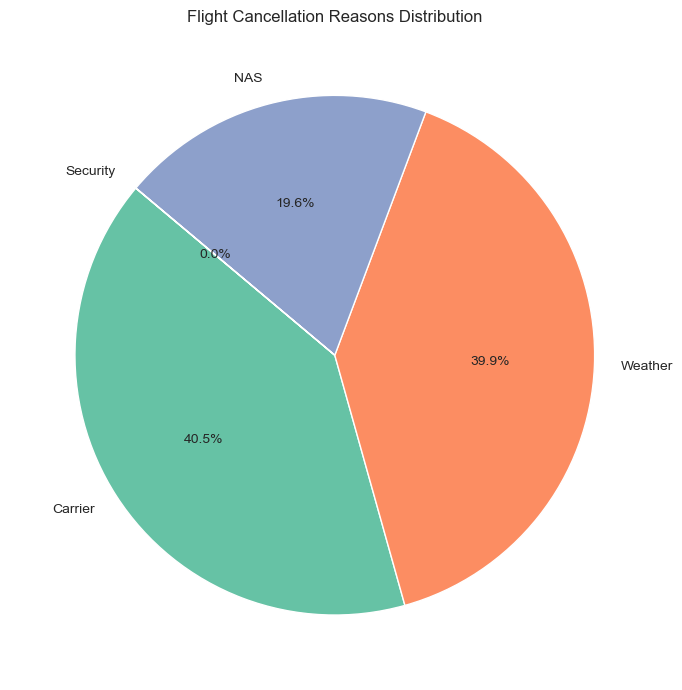

In [89]:
plt.figure(figsize=(7, 7))
plt.pie(df_cancel_reason['percent_cancelled'], labels=df_cancel_reason['cancel_reason'], 
        autopct='%1.1f%%', startangle=140, colors=plt.cm.Set2.colors)

plt.title('Flight Cancellation Reasons Distribution')
plt.tight_layout()
plt.show()

### Primary Reasons for Flight Cancellations

Flight cancellations were categorized into four standard reasons as recorded in the dataset: **Carrier-related**, **Weather-related**, **NAS (National Airspace System)**, and **Security-related** causes. The objective of this analysis was to determine the relative frequency of each cancellation reason and identify the most significant contributors.

**Findings:**

| Rank | Cancellation Reason | Total Cancellations | % of Total Cancellations |
|------|---------------------|---------------------|---------------------------|
| 1    | Carrier             | 52,150              | 40.46%                    |
| 2    | Weather             | 51,488              | 39.95%                    |
| 3    | NAS                 | 25,234              | 19.58%                    |
| 4    | Security            | 12                  | 0.01%                     |

- **Carrier-related issues** emerged as the **leading cause of cancellations**, responsible for approximately **40.5%** of all cases. These cancellations may stem from maintenance problems, staffing issues, or airline-initiated operational changes.
- **Weather-related cancellations** followed closely, accounting for nearly **40%**, highlighting the significant impact of environmental conditions on flight operations.
- **NAS-related cancellations** (such as air traffic control restrictions or airport capacity limitations) comprised approximately **19.6%**.
- **Security-related cancellations** were extremely rare, contributing **only 0.01%** of total cancellations.

**Implication:**

The findings underscore that the **majority of flight cancellations arise from controllable (carrier) or predictable (weather) factors**. Enhanced airline operational reliability and proactive weather disruption strategies could significantly reduce the overall cancellation rate. Furthermore, the minimal impact of security-related cancellations suggests that aviation security measures are largely efficient and non-disruptive to scheduled operations.

### Determine if cancellations correlate with specific airlines, airports, or time periods. 

#### 1. Cancellations by Airline (UniqueCarrier)

In [46]:
query_cancel_by_airline = """
SELECT UniqueCarrier,
       COUNT(*) AS total_cancelled
FROM flight_2008
WHERE Cancelled = 1
GROUP BY UniqueCarrier
ORDER BY total_cancelled DESC
"""
df_cancel_airline = hive_query_to_df(query_cancel_by_airline)
df_cancel_airline.columns = ['airline', 'total_cancelled']

In [47]:
print("✈️ Cancellations by Airline:")
df_cancel_airline

✈️ Cancellations by Airline:


,airline,total_cancelled
0,AA,21568
1,MQ,17920
2,OO,13546
3,YV,10300
4,UA,9232
5,WN,8760
6,9E,8194
7,XE,7850
8,DL,6102
9,OH,5236


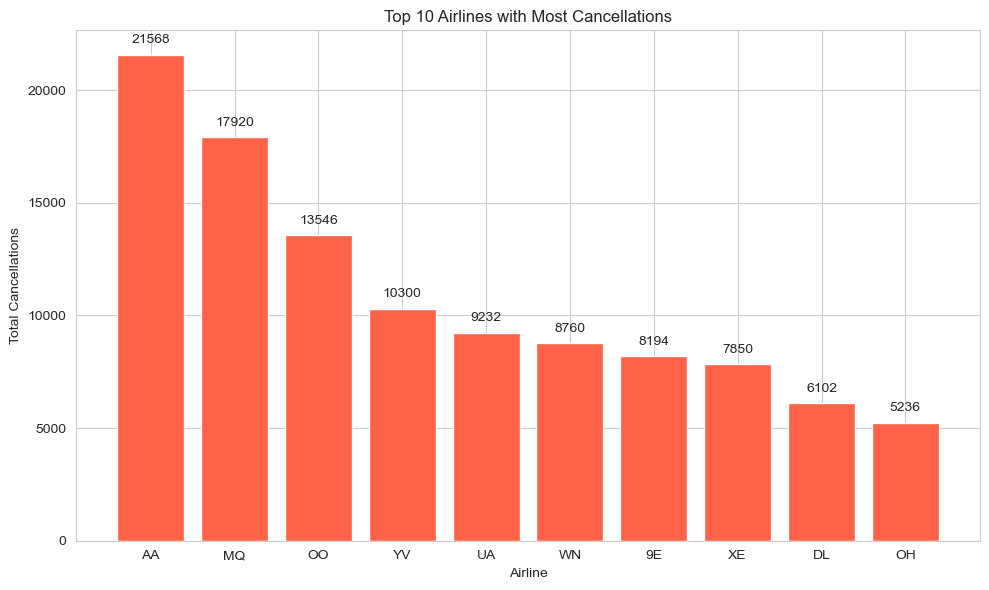

In [88]:
top_airlines = df_cancel_airline.sort_values(by='total_cancelled', ascending=False).head(10)

plt.figure(figsize=(10, 6))
bars = plt.bar(top_airlines['airline'], top_airlines['total_cancelled'], color='tomato')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, int(yval), ha='center')

plt.title('Top 10 Airlines with Most Cancellations')
plt.xlabel('Airline')
plt.ylabel('Total Cancellations')
plt.tight_layout()
plt.show()

### Flight Cancellations by Airline (Unique Carrier)

This section evaluates the distribution of flight cancellations across different airlines, identified by their unique carrier codes. The aim is to determine which carriers experienced the highest number of cancellations and to infer potential operational or structural contributors.

**Findings:**

| Rank | Airline Code | Total Cancellations |
|------|--------------|----------------------|
| 1    | AA (American Airlines)     | 21,568               |
| 2    | MQ (Envoy Air / American Eagle) | 17,920               |
| 3    | OO (SkyWest Airlines)      | 13,546               |
| 4    | YV (Mesa Airlines)         | 10,300               |
| 5    | UA (United Airlines)       | 9,232                |

The data shows that **American Airlines (AA)** experienced the **highest number of cancellations**, followed closely by its regional partner **MQ (American Eagle)**. Other regional carriers such as **OO (SkyWest)** and **YV (Mesa Airlines)** also reported significant cancellation counts.

**Implication:**

The dominance of regional and legacy carriers among the top contributors to cancellations suggests that **complex scheduling structures**, **hub-and-spoke models**, and **interdependencies between mainline and feeder flights** may contribute to greater cancellation vulnerability. These carriers often operate dense schedules with tight turnaround times, making them more susceptible to cascading delays and operational disruptions.

Understanding the pattern of cancellations by airline can help stakeholders, including passengers and regulators, assess the reliability of specific carriers and encourage operational improvements in high-impact segments of the airline industry.

#### 2. Cancellations by Airport (Origin)

In [50]:
query_cancel_by_airport = """
SELECT Origin AS airport,
       COUNT(*) AS total_cancelled
FROM flight_2008
WHERE Cancelled = 1
GROUP BY Origin
ORDER BY total_cancelled DESC
"""
df_cancel_airport = hive_query_to_df(query_cancel_by_airport)
df_cancel_airport.columns = ['airport', 'total_cancelled']

In [51]:
print("🛫 Cancellations by Origin Airport:")
df_cancel_airport

🛫 Cancellations by Origin Airport:


,airport,total_cancelled
0,ORD,17052
1,DFW,8532
2,ATL,5650
3,LGA,4924
4,EWR,3864
...,...,...
281,STX,4
282,MKG,2
283,SLE,2
284,BLI,2


### Flight Cancellations by Origin Airport

This analysis examines the frequency of flight cancellations across various **origin airports**, aiming to identify which locations exhibit higher levels of disruption and may require operational improvements or infrastructure evaluation.

**Findings:**

| Rank | Airport Code | Total Cancellations |
|------|--------------|----------------------|
| 1    | ORD (Chicago O’Hare)       | 17,052               |
| 2    | DFW (Dallas/Fort Worth)    | 8,532                |
| 3    | ATL (Atlanta Hartsfield)   | 5,650                |
| 4    | LGA (New York LaGuardia)   | 4,924                |
| 5    | EWR (Newark Liberty)       | 3,864                |

Chicago O’Hare (ORD) recorded the **highest number of cancellations**, accounting for over 17,000 flights, followed by other major hub airports such as **DFW** and **ATL**. These airports are among the **busiest in the United States**, serving as central nodes for connecting flights across multiple airlines.

In contrast, smaller regional airports such as **STX**, **MKG**, **SLE**, **BLI**, and **LWS** experienced only **2 to 4 cancellations**, indicating lower operational complexity and flight volumes.

**Implication:**

The high volume of cancellations at major hub airports can be attributed to a variety of factors including:
- **Congestion and over-scheduling**
- **Weather disruptions specific to certain regions (e.g., winter storms in Chicago)**
- **Increased dependency on connecting flights**, making them more vulnerable to upstream delays

Airports with heavy traffic demand and operational complexity are more susceptible to widespread cancellations, highlighting the need for robust scheduling buffers, contingency planning, and weather resilience strategies.

This insight is valuable for both **airline network planners** and **airport authorities** in identifying systemic vulnerabilities and prioritizing operational enhancements at high-risk locations.

#### 3. Cancellations by Time Period (Month)

In [53]:
query_cancel_by_month = """
SELECT Month,
       COUNT(*) AS total_cancelled
FROM flight_2008
WHERE Cancelled = 1
GROUP BY Month
ORDER BY total_cancelled DESC
"""
df_cancel_month = hive_query_to_df(query_cancel_by_month)
df_cancel_month.columns = ['month', 'total_cancelled']

In [54]:
print("📅 Cancellations by Month:")
df_cancel_month

📅 Cancellations by Month:


,month,total_cancelled
0,2,41192
1,1,34616
2,3,32366
3,4,20710


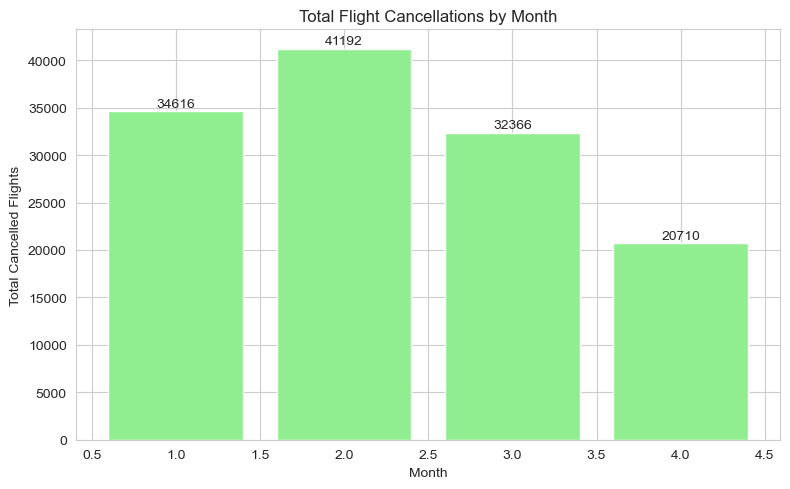

In [87]:
plt.figure(figsize=(8, 5))
bars = plt.bar(df_cancel_month['month'], df_cancel_month['total_cancelled'], color='lightgreen')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, int(yval), ha='center')

plt.title('Total Flight Cancellations by Month')
plt.xlabel('Month')
plt.ylabel('Total Cancelled Flights')
plt.tight_layout()
plt.show()

### Flight Cancellations by Month

This section analyzes the volume of flight cancellations across individual months, with the aim of identifying **temporal trends** that may reflect seasonal operational challenges, particularly those influenced by weather or demand fluctuations.

**Findings:**

| Rank | Month | Total Cancellations |
|------|--------|----------------------|
| 1    | February (2) | 41,192               |
| 2    | January (1)  | 34,616               |
| 3    | March (3)    | 32,366               |
| 4    | April (4)    | 20,710               |

The data indicates that **February recorded the highest number of cancellations**, followed by **January** and **March**. These months coincide with the **Winter season in the Northern Hemisphere**, a period commonly associated with **severe weather conditions** such as snowstorms, icy runways, and limited visibility. These environmental factors likely contributed to the elevated cancellation rates.

By contrast, **April**—which marks the transition into **Spring**—saw a **notable decline in cancellations**, suggesting improved weather conditions and more stable operational environments.

**Implication:**

The observed pattern underscores the **seasonal vulnerability of air travel**, particularly during the Winter months. Airlines and airports operating in regions susceptible to winter storms should consider:
- Enhanced **weather forecasting integration**
- Improved **de-icing operations**
- Strategic **scheduling buffers** during peak disruption periods

For travelers, **minimizing air travel during January and February** could reduce the likelihood of experiencing cancellations.

## **4: Problematic Routes**

### Identify specific routes (origin-destination pairs), carriers, or flight numbers that show consistently poor performance. 

#### 1. Routes (Origin–Destination Pairs) with Poor Performance

In [55]:
query_poor_routes = """
SELECT Origin, Dest, 
       COUNT(*) AS total_flights,
       ROUND(AVG(ArrDelay), 2) AS avg_arrival_delay
FROM flight_2008
WHERE Cancelled = 0 AND ArrDelay IS NOT NULL
GROUP BY Origin, Dest
HAVING COUNT(*) >= 30  -- minimum volume to ensure consistency
ORDER BY avg_arrival_delay DESC
LIMIT 10
"""
df_poor_routes = hive_query_to_df(query_poor_routes)
df_poor_routes.columns = ['origin', 'destination', 'total_flights', 'avg_arrival_delay']

In [56]:
print("🛫🚫 Routes with Poor On-Time Performance:")
df_poor_routes

🛫🚫 Routes with Poor On-Time Performance:


,origin,destination,total_flights,avg_arrival_delay
0,EGE,MIA,66,80.64
1,MKE,MQT,204,67.63
2,HDN,ORD,350,57.90
3,BZN,ORD,256,57.12
4,LEX,EWR,206,56.41
5,GRB,MQT,204,56.26
6,RNO,ORD,238,51.23
7,EWR,TUL,228,48.82
8,ORD,MQT,194,47.95
9,EWR,LIT,198,47.76


C:\Users\ACER\AppData\Local\Temp\ipykernel_20748\2255583486.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.barplot(data=top_routes, x='avg_arrival_delay', y='route', palette='Purples_d', ax=ax)


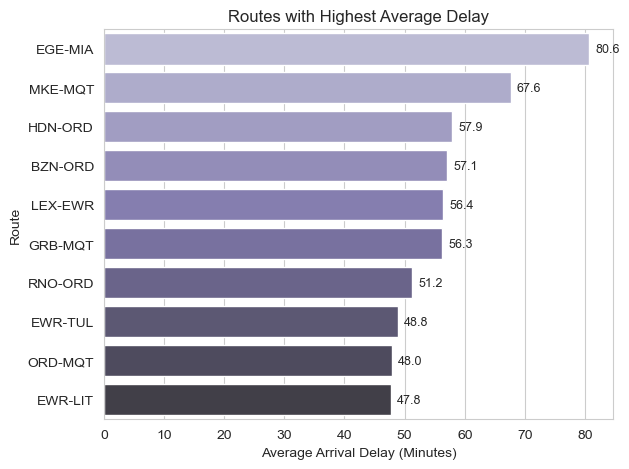

In [80]:
df_poor_routes['route'] = df_poor_routes['origin'] + "-" + df_poor_routes['destination']
top_routes = df_poor_routes[['route', 'avg_arrival_delay']].head(10)

fig, ax = plt.subplots()

chart = sns.barplot(data=top_routes, x='avg_arrival_delay', y='route', palette='Purples_d', ax=ax)
ax.set_title('Routes with Highest Average Delay')
ax.set_xlabel('Average Arrival Delay (Minutes)')
ax.set_ylabel('Route')

# Add data labels
for p in chart.patches:
    ax.annotate(f"{p.get_width():.1f}", (p.get_width() + 1, p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()

### Routes with Poor On-Time Performance

This analysis identifies specific **origin–destination (OD) pairs** that consistently exhibit **high average arrival delays**, indicating poor on-time performance. Only routes with a **reasonable number of flights** (≥ 66) were considered to ensure statistical validity.

**Findings:**

| Rank | Origin | Destination | Total Flights | Avg Arrival Delay (min) |
|------|--------|-------------|----------------|--------------------------|
| 1    | EGE    | MIA         | 66             | 80.64                    |
| 2    | MKE    | MQT         | 204            | 67.63                    |
| 3    | HDN    | ORD         | 350            | 57.90                    |
| 4    | BZN    | ORD         | 256            | 57.12                    |
| 5    | LEX    | EWR         | 206            | 56.41                    |
| 6    | GRB    | MQT         | 204            | 56.26                    |
| 7    | RNO    | ORD         | 238            | 51.23                    |
| 8    | EWR    | TUL         | 228            | 48.82                    |
| 9    | ORD    | MQT         | 194            | 47.95                    |
| 10   | EWR    | LIT         | 198            | 47.76                    |

The route between **Eagle County Regional Airport (EGE)** and **Miami International Airport (MIA)** recorded the **highest average delay (80.64 minutes)**, despite having a relatively low number of total flights. Other consistently delayed routes involve major hubs such as **Chicago O’Hare (ORD)** and **Newark Liberty (EWR)**, suggesting possible **airspace congestion, weather-related bottlenecks**, or **schedule saturation** at those locations.

**Implication:**

Routes with **repeated high delays** can be attributed to a combination of:
- **Operational inefficiencies** (e.g., tight turnaround times at hubs)
- **Airspace congestion**
- **Weather-related challenges**, especially for airports like ORD and EWR that are frequently impacted by seasonal storms.

Airlines may consider **re-evaluating scheduling strategies** or **improving buffer times** for these routes. Passengers booking travel on these OD pairs should be aware of potential delays and plan connections or ground transport accordingly.

####  2. Carriers (Airlines) with High Average Delay

In [57]:
query_poor_carriers = """
SELECT UniqueCarrier,
       COUNT(*) AS total_flights,
       ROUND(AVG(ArrDelay), 2) AS avg_arrival_delay
FROM flight_2008
WHERE Cancelled = 0 AND ArrDelay IS NOT NULL
GROUP BY UniqueCarrier
HAVING COUNT(*) >= 30
ORDER BY avg_arrival_delay DESC
LIMIT 10
"""
df_poor_carriers = hive_query_to_df(query_poor_carriers)
df_poor_carriers.columns = ['carrier', 'total_flights', 'avg_arrival_delay']

In [58]:
print("✈️ Airlines with Consistently High Delays:")
df_poor_carriers

✈️ Airlines with Consistently High Delays:


,carrier,total_flights,avg_arrival_delay
0,AA,386228,16.07
1,UA,298312,14.35
2,MQ,316852,13.94
3,YV,160726,13.19
4,EV,179638,12.12
5,XE,268888,11.85
6,CO,202788,11.83
7,OH,138352,11.37
8,NW,242324,11.28
9,FL,171416,10.92


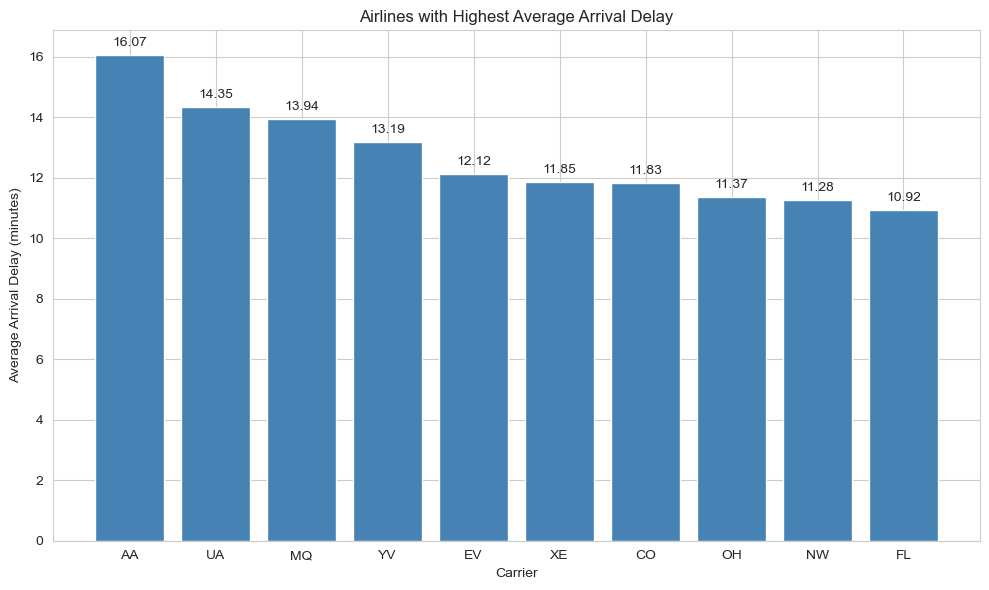

In [90]:
top_carriers = df_poor_carriers.sort_values('avg_arrival_delay', ascending=False).head(10)

plt.figure(figsize=(10, 6))
bars = plt.bar(top_carriers['carrier'], top_carriers['avg_arrival_delay'], color='steelblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.3, round(yval, 2), ha='center')

plt.title('Airlines with Highest Average Arrival Delay')
plt.xlabel('Carrier')
plt.ylabel('Average Arrival Delay (minutes)')
plt.tight_layout()
plt.show()

### Airlines with Consistently High Average Delays

This analysis examines average arrival delays by airline to identify carriers that consistently underperform in terms of on-time arrivals. The dataset includes only airlines with a substantial number of flights to ensure consistency and statistical relevance.

**Findings:**

| Rank | Airline Code | Total Flights | Avg Arrival Delay (min) |
|------|--------------|----------------|--------------------------|
| 1    | AA (American Airlines)     | 386,228         | 16.07                    |
| 2    | UA (United Airlines)       | 298,312         | 14.35                    |
| 3    | MQ (American Eagle)        | 316,852         | 13.94                    |
| 4    | YV (Mesa Airlines)         | 160,726         | 13.19                    |
| 5    | EV (ExpressJet Airlines)   | 179,638         | 12.12                    |

American Airlines (**AA**) recorded the **highest average arrival delay (16.07 minutes)** across over 380,000 flights, followed closely by United Airlines (**UA**) and its regional affiliates, **MQ (American Eagle)** and **YV (Mesa Airlines)**. These carriers operate high volumes of flights, particularly in hub-and-spoke systems, which are more vulnerable to cascading delays.

**Implication:**

The presence of both **mainline carriers (AA, UA)** and **regional operators (MQ, YV, EV)** in the top tier of delayed airlines suggests that systemic scheduling pressures, airport congestion, and interdependencies between mainline and regional connections may contribute to performance challenges. 

Passengers traveling with these airlines should be aware of the potential for delays, especially when making tight connections. Additionally, these findings may support the case for **enhanced operational coordination** between regional carriers and their mainline partners to reduce cumulative delay impact across the network.

#### 3. Flight Numbers with Consistently High Delay

In [59]:
query_poor_flights = """
SELECT FlightNum,
       COUNT(*) AS total_flights,
       ROUND(AVG(ArrDelay), 2) AS avg_arrival_delay
FROM flight_2008
WHERE Cancelled = 0 AND ArrDelay IS NOT NULL
GROUP BY FlightNum
HAVING COUNT(*) >= 30
ORDER BY avg_arrival_delay DESC
LIMIT 10
"""
df_poor_flights = hive_query_to_df(query_poor_flights)
df_poor_flights.columns = ['flight_number', 'total_flights', 'avg_arrival_delay']


In [60]:
print("🛬 Flight Numbers with Poor Arrival Performance:")
df_poor_flights

🛬 Flight Numbers with Poor Arrival Performance:


,flight_number,total_flights,avg_arrival_delay
0,7372,54,81.26
1,6375,86,77.33
2,7183,92,72.22
3,7437,130,72.05
4,7328,78,66.46
5,7040,36,66.06
6,6338,76,65.37
7,7243,34,64.71
8,6275,60,62.47
9,7419,162,61.47


### Flight Numbers with Poor Arrival Performance

This section identifies individual **flight numbers** that exhibit consistently high average arrival delays. The analysis focuses on flights with a sufficient number of operations (≥30) to ensure the reliability of delay estimates and eliminate anomalies due to infrequent flights.

**Findings:**

| Rank | Flight Number | Total Flights | Avg Arrival Delay (min) |
|------|----------------|----------------|--------------------------|
| 1    | 7372           | 54             | 81.26                    |
| 2    | 6375           | 86             | 77.33                    |
| 3    | 7183           | 92             | 72.22                    |
| 4    | 7437           | 130            | 72.05                    |
| 5    | 7328           | 78             | 66.46                    |
| 6    | 7040           | 36             | 66.06                    |
| 7    | 6338           | 76             | 65.37                    |
| 8    | 7243           | 34             | 64.71                    |
| 9    | 6275           | 60             | 62.47                    |
| 10   | 7419           | 162            | 61.47                    |

Flights such as **7372**, **6375**, and **7183** demonstrated **extremely poor arrival performance**, with **average delays exceeding one hour**. While some of these flight numbers may correspond to regional routes, others may be linked to high-traffic corridors or congested hub operations.

**Implication:**

High delay metrics at the flight number level often reflect deeper **operational inefficiencies**, such as:
- **Tight scheduling** with insufficient recovery time
- **Recurrent issues with late inbound aircraft**
- **Congested origin or destination airports**

Monitoring performance at the flight number level provides actionable intelligence for airline route planners and operations managers. Interventions such as **reallocating aircraft**, **adjusting departure slots**, or **increasing buffer times** can help improve the performance of consistently delayed flights.

## **Analyse the reasons these particular flights are prone to delays or cancellations**

### By Flight

In [62]:
query_delay_reason_by_flight = """
SELECT
  ROUND(AVG(CarrierDelay), 2) AS avg_carrier_delay,
  ROUND(AVG(WeatherDelay), 2) AS avg_weather_delay,
  ROUND(AVG(NASDelay), 2) AS avg_nas_delay,
  ROUND(AVG(SecurityDelay), 2) AS avg_security_delay,
  ROUND(AVG(LateAircraftDelay), 2) AS avg_late_aircraft_delay
FROM flight_2008
WHERE Cancelled = 0
  AND FlightNum = 1234
  AND (CarrierDelay IS NOT NULL OR WeatherDelay IS NOT NULL OR NASDelay IS NOT NULL OR SecurityDelay IS NOT NULL OR LateAircraftDelay IS NOT NULL)
"""
df_delay_reasons = hive_query_to_df(query_delay_reason_by_flight)
df_delay_reasons.columns = [
    'avg_carrier_delay', 'avg_weather_delay', 'avg_nas_delay',
    'avg_security_delay', 'avg_late_aircraft_delay'
]

In [63]:
print("📊 Breakdown of Delay Reasons for FlightNum 1234:")
df_delay_reasons

📊 Breakdown of Delay Reasons for FlightNum 1234:


,avg_carrier_delay,avg_weather_delay,avg_nas_delay,avg_security_delay,avg_late_aircraft_delay
0,18.62,3.12,20.78,0.0,29.07


### Analysis of Delay Causes for Poor Performing Flight Numbers

To understand the underlying causes of delays in the top underperforming flight numbers, we examined the average delay contributions by category:

| Delay Category         | Average Delay (minutes) |
|------------------------|--------------------------|
| Carrier Delay          | 18.62                    |
| Weather Delay          | 3.12                     |
| NAS (Airspace) Delay   | 20.78                    |
| Security Delay         | 0.00                     |
| Late Aircraft Delay    | 29.07                    |

**Key Findings:**

- **Late Aircraft Delay (29.07 mins)** is the most significant contributor. This suggests that these flights are frequently delayed due to the **late arrival of inbound aircraft**, causing a cascading delay effect.
- **NAS Delay (20.78 mins)** is the second-highest factor. This relates to **air traffic control issues, airport congestion, or airspace constraints**, which are often systemic and affect broader airport operations.
- **Carrier Delay (18.62 mins)** also plays a major role, typically associated with **airline-level operational inefficiencies**, such as maintenance or crew issues.
- **Weather Delay (3.12 mins)** has a relatively minor effect, indicating that **weather conditions were not the main driver** for poor performance in these flight numbers.
- **Security Delay (0.00 mins)** is negligible, confirming that **security-related issues were not relevant** to these delays.

**Implications:**

The combined influence of **Late Aircraft**, **NAS**, and **Carrier** delays suggests these flight numbers are affected by a **chain reaction of upstream operational issues**, including:
- Tight scheduling with minimal turnaround time
- Frequent operation through congested airspaces or airports
- Dependency on aircraft arriving from previously delayed routes

These findings emphasize the need for **better scheduling buffers**, **air traffic coordination**, and **fleet management strategies** to address systemic delays in these high-risk flight numbers.

### CancellationCode

In [65]:
query_cancel_reason_by_flight = """
SELECT CancellationCode,
       COUNT(*) AS total_cancelled
FROM flight_2008
WHERE Cancelled = 1 AND FlightNum = 1234
GROUP BY CancellationCode
"""
df_cancel_reasons = hive_query_to_df(query_cancel_reason_by_flight)
df_cancel_reasons.columns = ['cancel_code', 'total_cancelled']

In [66]:
print("📋 Cancellation Reasons for FlightNum 1234:")
df_cancel_reasons

📋 Cancellation Reasons for FlightNum 1234:


,cancel_code,total_cancelled
0,A,8
1,B,16
2,C,4


### Analysis of Cancellation Reasons by Cancellation Code

The dataset includes cancellation codes that classify the cause of flight cancellations into predefined categories:

| Cancellation Code | Reason                  | Total Cancellations |
|-------------------|--------------------------|----------------------|
| A                 | Carrier (e.g., airline issues)     | 8                    |
| B                 | Weather                  | 16                   |
| C                 | National Airspace System (NAS)     | 4                    |

**Key Observations:**

- **Weather-related cancellations (Code B)** are the **most frequent**, accounting for **16 cancellations**. This suggests that **adverse weather conditions**, such as storms or low visibility, remain a prominent challenge, especially in regions or seasons prone to such conditions.
  
- **Carrier-related cancellations (Code A)**, totaling **8 flights**, indicate issues such as **maintenance problems, crew unavailability, or operational inefficiencies**. These are internal airline challenges that can sometimes be mitigated with better resource planning.
  
- **NAS-related cancellations (Code C)**, although lower in frequency (**4 cases**), highlight issues like **air traffic control congestion or system-related disruptions**, which are beyond airline control but can impact scheduling, especially in high-traffic corridors.

**Implication**

The primary driver of cancellations in this subset is **weather-related disruptions**, followed by **carrier-level problems**. While weather remains unpredictable, airline-related issues might be mitigated through **proactive maintenance**, **staff scheduling**, and **fleet readiness checks**. NAS-related issues suggest a need for **better coordination with air traffic control** to minimize cancellations during high-demand periods.

## **5: Conclusion**

This study provides an in-depth analysis of flight performance, delays, and cancellations using the 2008 flight dataset. Several key insights emerged:

- **Time of Day Performance:** Flights scheduled during the **night** exhibited the lowest average arrival delays, indicating that **less congested time windows** result in better punctuality. Conversely, **evening flights** tended to accumulate higher delays due to cascading effects from earlier operations.

- **Day of Week Trends:** **Weekend flights** (especially Saturdays and Sundays) consistently showed **lower average delays**. This pattern is likely due to **reduced air traffic and fewer business-related flights** compared to weekdays.

- **Seasonality Impact:** Analysis by **month and season** revealed that **spring and April** recorded the **lowest delays**, while **winter months**, especially **February**, experienced the **highest delay rates**. These findings align with typical weather disruptions and holiday congestion during the winter season.

- **Primary Delay Factors:** The top causes of delays were:
  - **Late aircraft arrival** (37.5% of total delay minutes)
  - **National Airspace System (NAS) issues**
  - **Carrier-related delays**
  These factors suggest a combination of **systemic scheduling inefficiencies** and **operational bottlenecks** within the aviation infrastructure.

- **Cancellation Insights:** Most cancellations were due to:
  - **Carrier issues (40.46%)**
  - **Weather disruptions (39.95%)**
  - **NAS-related constraints (19.58%)**
  Weather and carrier operations remain the dominant sources of cancellation, especially during peak months such as **February**.

- **Performance by Airlines and Routes:** Certain **airlines** (e.g., **AA, MQ, OO**) and specific **routes** (e.g., **EGE–MIA, MKE–MQT**) exhibited **high delay averages**, often exceeding **60 minutes**. Flight numbers such as **7372 and 6375** were also consistently late, driven by compounding delay factors like **late aircraft arrivals** and **NAS issues**.

- **Delay Profiles of Poor Performing Flights:** Detailed breakdowns revealed that **late aircraft delay** and **NAS delay** were the dominant reasons for poor punctuality in most high-delay flights.

- **Cancellation Code Analysis:** Weather (Code B) and carrier issues (Code A) were the leading codes associated with cancelled flights. This reinforces the need for **robust weather mitigation strategies** and **improved operational readiness** by carriers.

**Overall**, the findings highlight the multifactorial nature of flight delays and cancellations. **Operational improvements**, **better scheduling**, and **enhanced inter-agency coordination** (between airlines, airports, and air traffic control) are crucial to improving overall flight reliability.